<a href="https://colab.research.google.com/github/bcbao/bcbao/blob/main/Viet_Acne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Step 1: Install Necessary Libraries
# Install the required dependencies
!pip install torch torchvision torchaudio
!pip install git+https://github.com/facebookresearch/segment-anything.git

# Download the SAM model checkpoint
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h_4b8939.pth


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-6wnrn5oi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-6wnrn5oi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-07-17 00:28:33--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.70, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   323MB/s    in 7.3s    

2024-07-17 00:28:40 (337 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
#Step 2: Load the CLIP Model
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

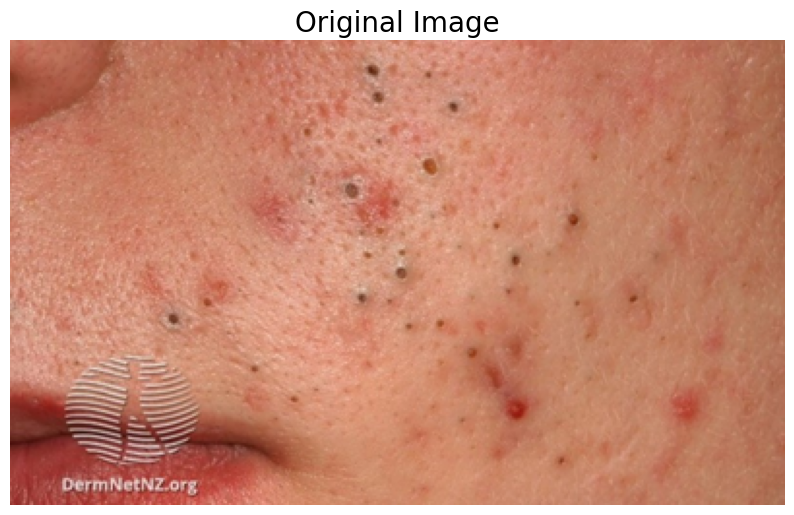

    Lesion Number Lesion Type   Area  Predicted IoU        Point Coordinates  \
0               1     nodules    122       0.926779         [[362.5, 155.0]]   
1               2    pustules    157       0.925397         [[347.5, 195.0]]   
2               3  whiteheads   3008       0.998735      [[37.65625, 175.0]]   
3               4     nodules    740       0.957400       [[7.53125, 185.0]]   
4               5     nodules    156       0.937732     [[128.03125, 185.0]]   
5               6    pustules    220       0.870003     [[112.96875, 125.0]]   
6               7     nodules   1688       1.009838   [[37.65625, 15.09375]]   
7               8     nodules    348       0.910835  [[188.28125, 85.53125]]   
8               9    pustules    496       0.973817        [[68.75, 228.75]]   
9              10     nodules   1028       0.952954        [[56.25, 206.25]]   
10             11     nodules    837       0.936316        [[81.25, 206.25]]   
11             12     nodules   2483    

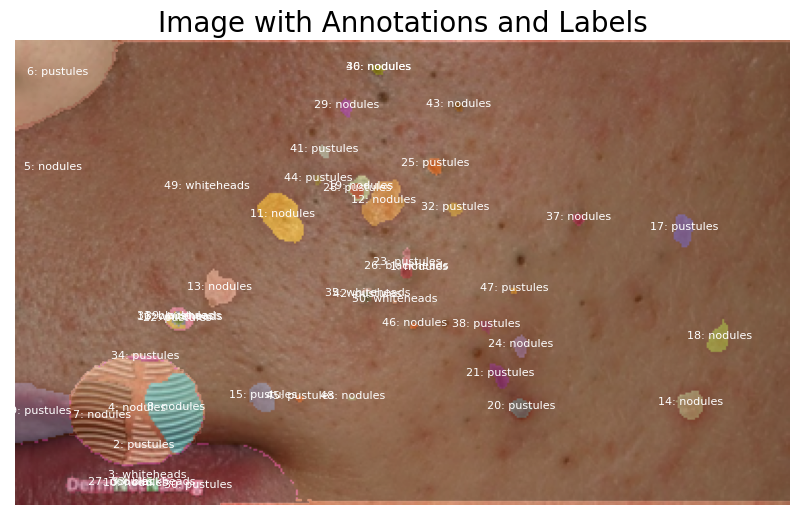

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import requests
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import pandas as pd

# Function to show annotations with labels
def show_anns_with_labels(anns, labels, image):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for i, (ann, label) in enumerate(zip(sorted_anns, labels)):
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
        plt.text(np.mean(np.where(m)[1]), np.mean(np.where(m)[0]), f'{i+1}: {label.split(":")[0]}', color='white', fontsize=8, ha='center')
    ax.imshow(img)

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load the image from URL
image_url = 'https://appnhs24wp41a8c38064.blob.core.windows.net/blobappnhs24wp41a8c38064/wp-content/uploads/2023/02/acne-2.jpg'
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

# Reduce image resolution to reduce memory usage
image = image.resize((image.width // 2, image.height // 2))

image_np = np.array(image)

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.axis('off')
plt.title('Original Image', fontsize=20)
plt.show()

# Load the SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)

# Generate masks using SamAutomaticMaskGenerator
masks = mask_generator.generate(image_np)

# Define lesion types with detailed descriptions
lesion_descriptions = [
    "blackheads: small black or yellowish bumps that develop on the skin; not filled with dirt, but are black because the inner lining of the hair follicle produces pigmentation.",
    "whiteheads: similar to blackheads, but may be firmer and won’t empty when squeezed.",
    "papules: small red bumps that may feel tender or sore.",
    "pustules: similar to papules, but have a white tip in the center, caused by a build-up of pus.",
    "nodules: large hard lumps that build up beneath the surface of the skin and can be painful.",
    "cysts: the most severe type of spot caused by acne; large pus-filled lumps that look similar to boils and carry the greatest risk of causing permanent scarring."
]
text_inputs = processor(text=lesion_descriptions, return_tensors="pt", padding=True)

# Function to classify lesion using CLIP with mixed precision
def classify_lesion(lesion_img):
    lesion_img_pil = Image.fromarray(lesion_img)
    image_input = processor(images=lesion_img_pil, return_tensors="pt", padding=True)
    with torch.cuda.amp.autocast():  # Enable mixed precision
        outputs = model(**image_input, **text_inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)  # Probability distribution over classes
    return lesion_descriptions[probs.argmax()]

# Classify each detected lesion in batches to reduce memory usage
classified_lesions = []
lesion_data = []
batch_size = 10
for i in range(0, len(masks), batch_size):
    batch_masks = masks[i:i+batch_size]
    for j, mask in enumerate(batch_masks):
        segmentation = mask['segmentation']
        lesion_img = image_np[segmentation]
        lesion_type = classify_lesion(lesion_img)
        classified_lesions.append(lesion_type)
        lesion_data.append({
            "Lesion Number": i + j + 1,
            "Lesion Type": lesion_type.split(":")[0],
            "Area": mask['area'],
            "Predicted IoU": mask['predicted_iou'],
            "Point Coordinates": mask['point_coords'],
            "Stability Score": mask['stability_score']
        })

# Create a DataFrame for the lesion data
lesion_df = pd.DataFrame(lesion_data)
print(lesion_df)

# Visualize the results
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
show_anns_with_labels(masks, classified_lesions, image_np)
plt.axis('off')
plt.title('Image with Annotations and Labels', fontsize=20)
plt.show()


In [ ]:
# Function to remove specific lesion numbers from the DataFrame
def remove_lesions(df, lesion_numbers):
    return df[~df['Lesion Number'].isin(lesion_numbers)]

# Specify lesion numbers to remove
lesion_numbers_to_remove = [6, 9, 34, 7, 4, 8, 2, 3, 27, 10, 30, 37, 12, 13, 21]  # Example lesion numbers to remove

# Remove specified lesion numbers and print the updated DataFrame
updated_lesion_df = remove_lesions(lesion_df, lesion_numbers_to_remove)
print("Updated DataFrame after removing specified lesion numbers:")
print(updated_lesion_df)

Updated DataFrame after removing specified lesion numbers:
    Lesion Number Lesion Type  Area  Predicted IoU        Point Coordinates  \
0               1     nodules   122       0.926779         [[362.5, 155.0]]   
4               5     nodules   156       0.937732     [[128.03125, 185.0]]   
10             11     nodules   837       0.936316        [[81.25, 206.25]]   
13             14     nodules   128       0.921449       [[343.75, 101.25]]   
14             15    pustules   416       0.918001        [[143.75, 93.75]]   
15             16  whiteheads   113       0.907760        [[181.25, 71.25]]   
16             17    pustules   135       0.897112        [[81.25, 138.75]]   
17             18     nodules    81       0.955621         [[257.5, 185.0]]   
18             19     nodules    65       0.901826         [[257.5, 155.0]]   
19             20    pustules     4       0.900575         [[197.5, 135.0]]   
21             22    pustules    28       0.955157      [[82.84375, 145.

In [ ]:
import pandas as pd
import numpy as np

# Define the total skin area (using example dimensions, adjust as needed)
total_skin_area = image.height * image.width

# Group by 'Lesion Type' and calculate statistics
lesion_stats = updated_lesion_df.groupby('Lesion Type').agg(
    count=('Lesion Number', 'count'),
    sum_area=('Area', 'sum'),
    mean_area=('Area', 'mean'),
).reset_index()

# Calculate the total lesion area
total_lesion_area = lesion_stats['sum_area'].sum()

# Calculate the percentage of the total skin area occupied by lesions
lesion_stats['percentage_of_total_skin'] = (lesion_stats['sum_area'] / total_skin_area) * 100

# Calculate the percentage of the total lesion area for each lesion type
lesion_stats['percentage_area'] = (lesion_stats['sum_area'] / total_lesion_area) * 100

# Format the percentages as strings with two decimal places
lesion_stats['percentage_of_total_skin'] = lesion_stats['percentage_of_total_skin'].map("{:.2f}%".format)
lesion_stats['percentage_area'] = lesion_stats['percentage_area'].map("{:.2f}%".format)

# Add the overall lesion area as a percentage of the total skin area
total_lesion_percentage = (total_lesion_area / total_skin_area) * 100

# Calculate the total number of lesions from the entire DataFrame
total_lesions_count = updated_lesion_df.shape[0]

# Print the summary statistics table
print(f"Total number of lesions: {total_lesions_count}")
print("Summary Statistics by Lesion Type:")
print(lesion_stats[['Lesion Type', 'count', 'sum_area', 'percentage_of_total_skin', 'percentage_area']])
print(f"Total lesion area as a percentage of the total skin area: {total_lesion_percentage:.2f}%")

# Extract coordinates for all lesions
all_lesions = updated_lesion_df[updated_lesion_df['Lesion Type'].isin(['blackheads', 'whiteheads'])]

# Function to parse point coordinates from string representation
def parse_coordinates(coord):
    if isinstance(coord, str):
        return np.array(eval(coord)[0])
    elif isinstance(coord, list) or isinstance(coord, tuple):
        return np.array(coord[0])
    else:
        raise ValueError("Unsupported coordinate format")

# Create multi-index labels
lesion_labels = [(row['Lesion Type'], row['Lesion Number']) for _, row in all_lesions.iterrows()]

# Initialize an empty DataFrame for the pairwise distance matrix
distance_matrix = pd.DataFrame(index=pd.MultiIndex.from_tuples(lesion_labels), columns=pd.MultiIndex.from_tuples(lesion_labels))

# Calculate distances between each pair of lesions
for i, (_, row1) in enumerate(all_lesions.iterrows()):
    coords1 = parse_coordinates(row1['Point Coordinates'])
    for j, (_, row2) in enumerate(all_lesions.iterrows()):
        coords2 = parse_coordinates(row2['Point Coordinates'])
        distance = np.linalg.norm(coords1 - coords2)
        distance_matrix.iloc[i, j] = f"{distance:.2f}"

# Print the pairwise distance matrix
print("Pairwise Distance Matrix (in pixels):")
print(distance_matrix)




Total number of lesions: 35
Summary Statistics by Lesion Type:
  Lesion Type  count  sum_area percentage_of_total_skin percentage_area
0  blackheads      3       110                    0.11%           3.75%
1     nodules     13      1635                    1.70%          55.80%
2    pustules     15       993                    1.03%          33.89%
3  whiteheads      4       192                    0.20%           6.55%
Total lesion area as a percentage of the total skin area: 3.05%
Pairwise Distance Matrix (in pixels):
              whiteheads blackheads                 whiteheads               
                      16         26      31      33         35      49     50
whiteheads 16       0.00      49.01   56.59   56.59      28.04   60.00  25.00
blackheads 26      49.01       0.00  101.04  101.04      74.84   27.43  64.28
           31      56.59     101.04    0.00    0.00      50.28  116.37  64.65
           33      56.59     101.04    0.00    0.00      50.28  116.37  64.65
whitehe

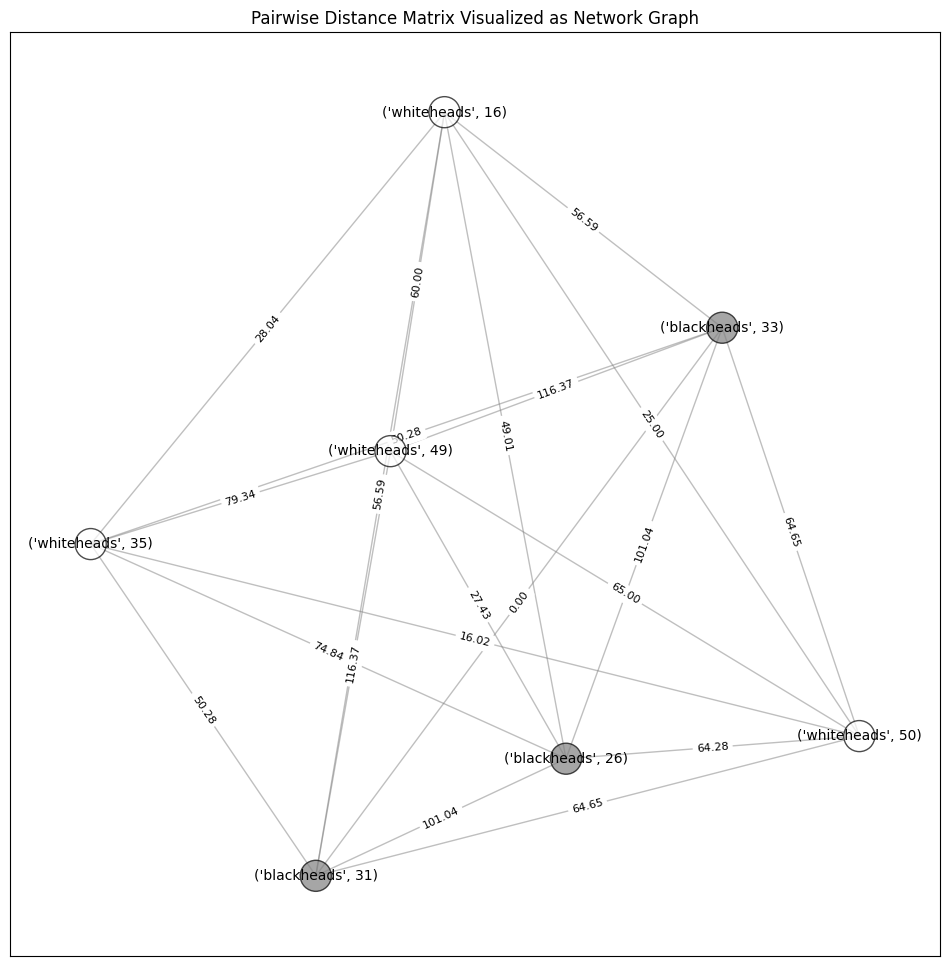

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


# Calculate distances between each pair of lesions
for i, (_, row1) in enumerate(all_lesions.iterrows()):
    coords1 = parse_coordinates(row1['Point Coordinates'])
    for j, (_, row2) in enumerate(all_lesions.iterrows()):
        coords2 = parse_coordinates(row2['Point Coordinates'])
        distance = np.linalg.norm(coords1 - coords2)
        distance_matrix.iloc[i, j] = f"{distance:.2f}"

# Create the network graph
G = nx.Graph()

# Add nodes
for label in lesion_labels:
    G.add_node(label)

# Add edges with weights (distances)
for i, (_, row1) in enumerate(all_lesions.iterrows()):
    for j, (_, row2) in enumerate(all_lesions.iterrows()):
        if i < j:  # To avoid duplicate edges and self-loops
            G.add_edge((row1['Lesion Type'], row1['Lesion Number']),
                       (row2['Lesion Type'], row2['Lesion Number']),
                       weight=float(distance_matrix.iloc[i, j]))

# Draw the network graph
pos = nx.spring_layout(G, seed=42)  # Positions for all nodes
plt.figure(figsize=(12, 12))

# Draw nodes with different colors for blackheads and whiteheads
node_colors = ['white' if label[0] == 'whiteheads' else 'gray' for label in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, edgecolors='black', alpha=0.7)

# Draw edges
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=1, edge_color='gray', alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}  # Format edge labels to 2 decimal places
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_family='sans-serif')

plt.title("Pairwise Distance Matrix Visualized as Network Graph")
plt.show()


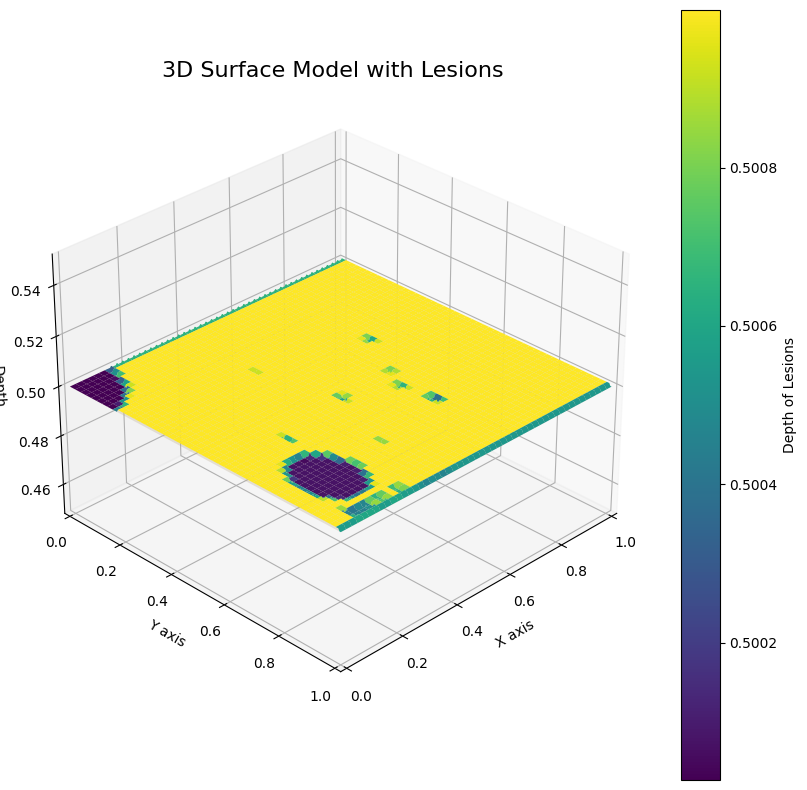

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from PIL import Image
import requests
from io import BytesIO


# Create a depth map (simplified example)
depth_map = np.zeros(image_np.shape[:2], dtype=np.float32)
for mask in masks:
    segmentation = mask['segmentation']
    depth_map[segmentation] = mask['area']  # Using area as a placeholder for depth

# Normalize the depth map
depth_map = depth_map / np.max(depth_map)

# Create a base layer to simulate thin skin layer in the middle of the z axis
skin_layer = np.ones_like(depth_map) * 0.5

# Create x, y, z data for 3D plot
x = np.linspace(0, 1, depth_map.shape[1])
y = np.linspace(0, 1, depth_map.shape[0])
x, y = np.meshgrid(x, y)
z_skin = skin_layer
z_depth = skin_layer + (depth_map - 0.001) * 0.001  # Adjusting to make depth less pronounced

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot skin layer
skin_surface = ax.plot_surface(x, y, z_skin, color='wheat', alpha=0.3, edgecolor='none')
# Plot depth map on top of the skin layer
depth_surface = ax.plot_surface(x, y, z_depth, cmap='viridis', edgecolor='none')

fig.colorbar(depth_surface, ax=ax, label='Depth of Lesions')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Depth')
ax.set_title('3D Surface Model with Lesions', fontsize=16)

# Adjust the view angle
ax.view_init(elev=30, azim=225)

# Adjust the axes limits to center the skin layer
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_zlim(0.45, 0.55)

plt.show()
